In [1]:
%matplotlib inline

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN

In this notebook I practice with the different elements of what I will put together as a pipeline to provide me with a categorisation of CVPR 2018 papers. The process will be based on representing the papers by means of a bag of words approach.

## Bag of words model

In [2]:
# Selecting the papers to process (see notebook 2)
papers = sorted(glob.glob('data/*.txt'))
df = pd.DataFrame(columns=['paper', 'len'], index=range(len(papers)))

i = 0
for paper in papers:
    with open(paper, 'r') as f:
        text = f.readlines()
    df.iloc[i, :] = [paper, len(text[0])]
    i = i + 1
df = df[~(df['len'] < 5000) & ~(df['len'] > 80000)]

In [3]:
papers = df.paper.values.tolist()

In [4]:
count_vect = TfidfVectorizer(input='filename', max_df = 0.7, min_df = 0.3)
X_freq = count_vect.fit_transform(papers)
X_freq.shape

(966, 867)

In [5]:
count_vect.vocabulary_

{'00': 0,
 '000': 1,
 '01': 2,
 '02': 3,
 '05': 4,
 '100': 5,
 '128': 6,
 '173': 7,
 '200': 8,
 '2004': 9,
 '2005': 10,
 '2006': 11,
 '2007': 12,
 '2008': 13,
 '2009': 14,
 '2010': 15,
 '2011': 16,
 '2018': 17,
 '256': 18,
 '2d': 19,
 '3d': 20,
 '44': 21,
 '46': 22,
 '47': 23,
 '48': 24,
 '49': 25,
 '51': 26,
 '52': 27,
 '53': 28,
 '54': 29,
 '55': 30,
 '56': 31,
 '57': 32,
 '58': 33,
 '59': 34,
 '61': 35,
 '62': 36,
 '63': 37,
 '64': 38,
 '65': 39,
 '66': 40,
 '67': 41,
 '68': 42,
 '69': 43,
 '70': 44,
 '71': 45,
 '72': 46,
 '73': 47,
 '74': 48,
 '75': 49,
 '76': 50,
 '77': 51,
 '78': 52,
 '79': 53,
 '80': 54,
 '81': 55,
 '82': 56,
 '83': 57,
 '84': 58,
 '85': 59,
 '86': 60,
 '87': 61,
 '88': 62,
 '89': 63,
 '90': 64,
 '91': 65,
 '92': 66,
 '93': 67,
 '94': 68,
 '95': 69,
 '96': 70,
 '97': 71,
 '98': 72,
 '99': 73,
 'ability': 74,
 'ablation': 75,
 'able': 76,
 'about': 77,
 'above': 78,
 'according': 79,
 'accurate': 80,
 'achieved': 81,
 'achieves': 82,
 'acm': 83,
 'across': 84,
 '

In [6]:
X_freq[0,1]

0.039063045941197076

## LSA

In [7]:
X_lsa = TruncatedSVD(n_components=15, random_state=0).fit_transform(X_freq)

## Paper similarity

In [8]:
X_embedded = TSNE(n_components=2).fit_transform(X_lsa)

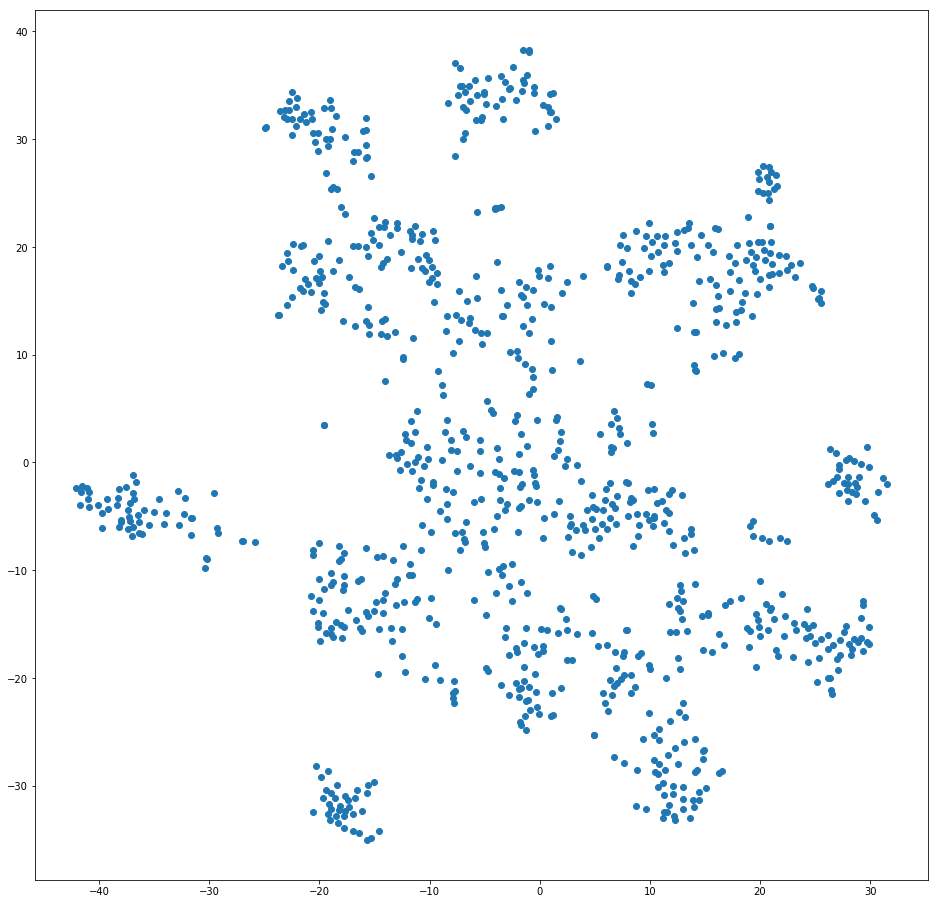

In [9]:
fig, ax = plt.subplots()
ax.scatter(X_embedded[:,0], X_embedded[:,1])
fig.set_figwidth(16)
fig.set_figheight(16)

## Clustering

In [10]:
# Model selection
RANGE_K = range(2, 100)
best_kmeans = None
max_shil = -1
shils = []
for k in tqdm(RANGE_K):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_embedded)
    shil = silhouette_score(X_embedded, kmeans.labels_)
    shils.append(shil)
    if shil > max_shil:
        max_shil = shil
        best_kmeans = kmeans
kmeans = best_kmeans

100%|██████████| 98/98 [00:24<00:00,  4.03it/s]


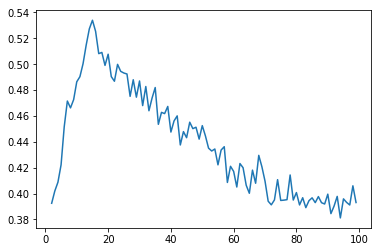

In [11]:
fig, ax = plt.subplots()
ax.plot(RANGE_K, shils)

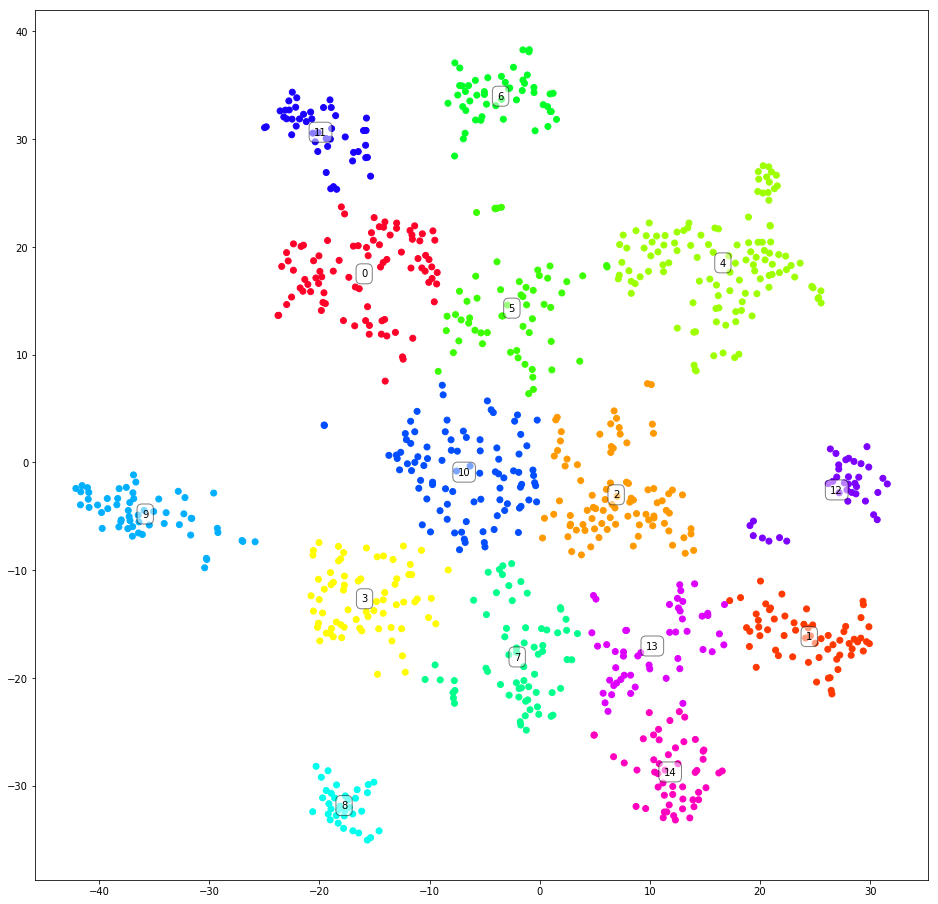

In [12]:
fig, ax = plt.subplots()
ax.scatter(X_embedded[:,0], X_embedded[:,1], c = kmeans.labels_, cmap="gist_rainbow")
i = 0
for c in kmeans.cluster_centers_:
    plt.annotate(
        str(i),
        xy=(c[0], c[1]), xytext=(0,0),
        textcoords='offset points', ha='center', va='center',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))
    i = i + 1
fig.set_figwidth(16)
fig.set_figheight(16)

In [13]:
for i in np.unique(kmeans.labels_.tolist()):
    indexes = np.where(kmeans.labels_ == i)
    papers_cluster = np.array(papers)[indexes].tolist()
    print('CLUSTER ' + str(i))
    for p in papers_cluster:
        print('   ' + p.replace('data/', ''))
    print('=====================')

CLUSTER 0
   Agudo_Image_Collection_Pop-Up_CVPR_2018_paper.txt
   Alldieck_Video_Based_Reconstruction_CVPR_2018_paper.txt
   Anirudh_Lose_the_Views_CVPR_2018_paper.txt
   Balakrishnan_An_Unsupervised_Learning_CVPR_2018_paper.txt
   Barnea_Curve_Reconstruction_via_CVPR_2018_paper.txt
   Birdal_A_Minimalist_Approach_CVPR_2018_paper.txt
   Bone_Learning_Distributions_of_CVPR_2018_paper.txt
   Chu_SurfConv_Bridging_3D_CVPR_2018_paper.txt
   Dai_ScanComplete_Large-Scale_Scene_CVPR_2018_paper.txt
   Deng_PPFNet_Global_Context_CVPR_2018_paper.txt
   Esser_A_Variational_U-Net_CVPR_2018_paper.txt
   Fang_Planar_Shape_Detection_CVPR_2018_paper.txt
   Feng_GVCNN_Group-View_Convolutional_CVPR_2018_paper.txt
   Fujimura_Photometric_Stereo_in_CVPR_2018_paper.txt
   Graham_3D_Semantic_Segmentation_CVPR_2018_paper.txt
   He_Triplet-Center_Loss_for_CVPR_2018_paper.txt
   Hua_Pointwise_Convolutional_Neural_CVPR_2018_paper.txt
   Huang_Recurrent_Slice_Networks_CVPR_2018_paper.txt
   Isokane_Probabilistic

In [14]:
# Overall clustering score
silhouette_score(X_embedded, kmeans.labels_)

0.5339931

In [15]:
# Silhouette score per sample
# User to calculate the mean silouette score for each cluster
scores = silhouette_samples(X_embedded, kmeans.labels_)
df_scores = df.copy()
df_scores['label'] = kmeans.labels_
df_scores['shil'] = scores
df_scores.groupby('label').mean().sort_values(by='shil', ascending=False)

,shil
label,
8,0.848738
9,0.725072
6,0.716614
11,0.679382
12,0.637184
14,0.596981
1,0.582470
3,0.576477
4,0.542377


## DBSCAN

In [16]:
RANGE_EPS = np.arange(0.01, 5, 0.01)
RANGE_MIN_SAMPLES = range(3,50)
parameters = []
for eps in RANGE_EPS:
    for min_samples in RANGE_MIN_SAMPLES:
        parameters.append([eps, min_samples])

best_dbscan = None
max_shil = -1
shils = []
for i in tqdm(range(len(parameters))):
    dbscan = DBSCAN(eps=parameters[i][0], min_samples=parameters[i][1]).fit(X_embedded)
    if len(np.unique(dbscan.labels_).tolist()) > 1:
        shil = silhouette_score(X_embedded, dbscan.labels_)
        shils.append(shil)
        if shil > max_shil:
            max_shil = shil
            best_dbscan = dbscan
    else:
        shils.append(-1)
dbscan = best_dbscan

100%|██████████| 23453/23453 [04:02<00:00, 96.60it/s] 


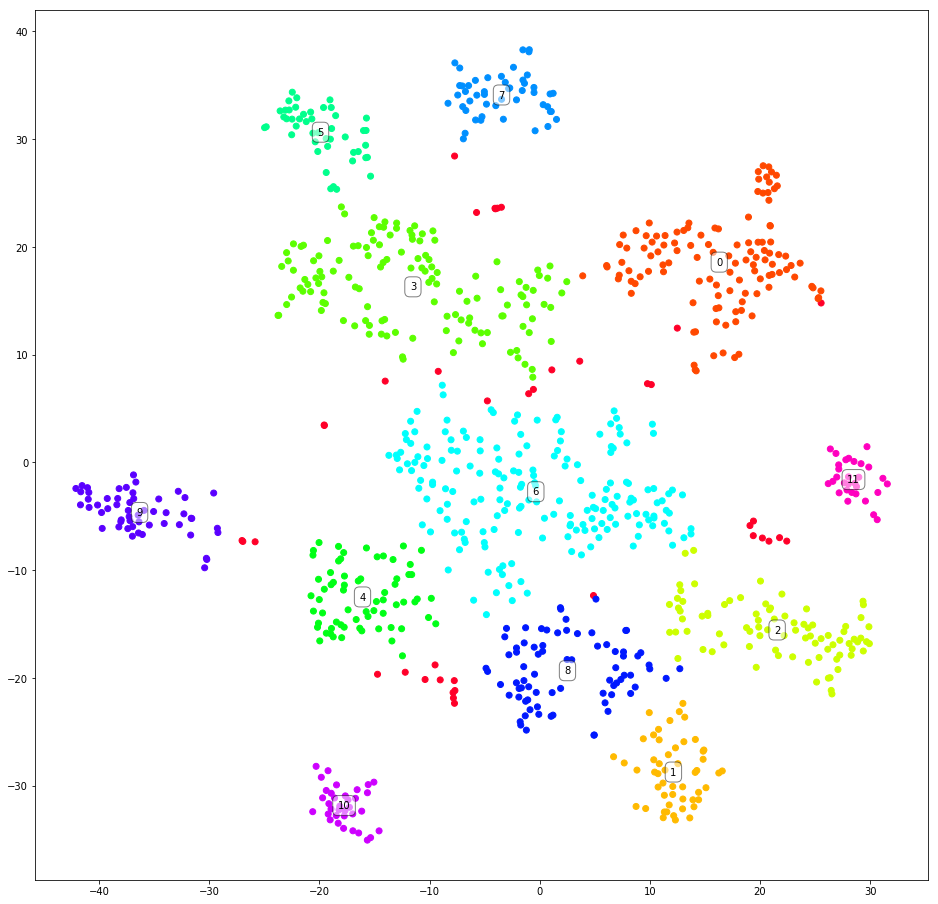

In [17]:
fig, ax = plt.subplots()
ax.scatter(X_embedded[:,0], X_embedded[:,1], c = dbscan.labels_, cmap="gist_rainbow")

labels = np.unique(dbscan.labels_).tolist()

for i in range(len(labels)):
    if labels[i] != -1:
        center = [np.mean(X_embedded[dbscan.labels_ == labels[i], 0]), 
                  np.mean(X_embedded[dbscan.labels_ == labels[i], 1])]
        plt.annotate(
            str(labels[i]),
            xy=(center[0], center[1]), xytext=(0,0),
            textcoords='offset points', ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))
fig.set_figwidth(16)
fig.set_figheight(16)

In [18]:
# Overall clustering score
silhouette_score(X_embedded, dbscan.labels_)

0.47133857

In [19]:
# Silhouette score per sample
# User to calculate the mean silouette score for each cluster
scores = silhouette_samples(X_embedded, dbscan.labels_)
df_scores = df.copy()
df_scores['label'] = dbscan.labels_
df_scores['shil'] = scores
df_scores.groupby('label').mean().sort_values(by='shil', ascending=False)

,shil
label,
10,0.850359
11,0.832435
9,0.762950
7,0.731337
5,0.724659
4,0.672581
1,0.662678
0,0.596771
8,0.466678


## Conclusion

I am ready to put all of this together into a pipeline in order to apply model selection. These are the parameters I have to deal with:

- min_df and max_df in TfidfVectorizer
- n_components in TruncatedSVD
- n_clusters in KMeans, or eps and min_samples in DBSCAN